### Imports

In [443]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn, rand
from scipy.io import loadmat
import time
from functools import wraps
import picos as pc

### Runtime

In [444]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [445]:
# Note that there are several shapes in the LASA Handwriting dataset

name_of_dataset = 'Angle'
#name_of_dataset = 'CShape'
# name_of_dataset = 'GShape'
#name_of_dataset = 'JShape'
# name_of_dataset = 'Sshape'
#name_of_dataset = 'Worm'
#name_of_dataset = 'Multi_Models_1'
#name_of_dataset = 'Multi_Models_2'
#name_of_dataset = 'Multi_Models_3'
#name_of_dataset = 'Multi_Models_4' # two pattern

dataset = loadmat("../Dataset/" + name_of_dataset + '.mat')
# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0,0][0].shape[0]
dim_of_function = size_of_state 

In [446]:
"""
# We need an init position for future simulation of learnt system
init_position_of_demos = np.zeros((size_of_state, num_of_demos))
x_cell = np.zeros((1, num_of_demos))
y_cell = np.zeros((1, num_of_demos))

# Python way to recreate cell array in matlab
x_cell = None 
y_cell = None

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_demos):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2] # is at position 3 in .mat file
    init_position_of_demos[:,i] = position_dataseries[:,0]
    # create x_cell if not existing
    if x_cell is None:
        x_cell = position_dataseries
    else : 
        # Example: two arrays of (2,1000) (2,1000) -> get 1 array with (2,2000)
        x_cell = np.concatenate((x_cell, position_dataseries), axis = 1)
    if y_cell is None:
        y_cell = velocity_dataseries
    else : 
        y_cell = np.concatenate((y_cell, velocity_dataseries), axis = 1)

x_train = x_cell # (2, 7000)
y_train = y_cell

num_of_points = x_train.shape[1]

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0] # good

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1]

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1) # axis = 1 is to concatenate at the second dimension
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries

# Intial starting point for the simulated trajectory using learnt model
#init_condition = stat.mean(init_position_of_demos[1]) # Average starting point of all demos
init_condition = init_position_of_demos.mean(axis = 1) # computes the mean across each columns
print(init_condition)

"""

"\n# We need an init position for future simulation of learnt system\ninit_position_of_demos = np.zeros((size_of_state, num_of_demos))\nx_cell = np.zeros((1, num_of_demos))\ny_cell = np.zeros((1, num_of_demos))\n\n# Python way to recreate cell array in matlab\nx_cell = None \ny_cell = None\n\n# Concatenating the dataseries of position and velocities\nfor i in range(0, num_of_demos):\n    demo_struct = dataset['demos'][0,i][0,0]\n\n    position_dataseries = dataset['demos'][0,i][0,0][0]\n    velocity_dataseries = dataset['demos'][0,i][0,0][2] # is at position 3 in .mat file\n    init_position_of_demos[:,i] = position_dataseries[:,0]\n    # create x_cell if not existing\n    if x_cell is None:\n        x_cell = position_dataseries\n    else : \n        # Example: two arrays of (2,1000) (2,1000) -> get 1 array with (2,2000)\n        x_cell = np.concatenate((x_cell, position_dataseries), axis = 1)\n    if y_cell is None:\n        y_cell = velocity_dataseries\n    else : \n        y_cell = 

#### Mean of dataset

In [447]:
num_of_train_datasets = 4
#init_position_of_demos = np.zeros((size_of_state, num_of_train_datasets))

pos_cell_1 = np.zeros((1000, num_of_train_datasets))
pos_cell_2 = np.zeros((1000, num_of_train_datasets))
vel_cell_1 = np.zeros((1000, num_of_train_datasets))
vel_cell_2 = np.zeros((1000, num_of_train_datasets))

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2] # is at position 3 in .mat file
    #init_position_of_demos[:,i] = position_dataseries[:,0]

    pos_cell_1[:, i] = position_dataseries[0]
    pos_cell_2[:, i] = position_dataseries[1]
    vel_cell_1[:, i] = velocity_dataseries[0]
    vel_cell_2[:, i] = velocity_dataseries[1]

x_train_1 = pos_cell_1.mean(axis=1) # computes the mean across each columns
x_train_2 = pos_cell_2.mean(axis=1) # computes the mean across each columns
y_train_1 = vel_cell_1.mean(axis=1) # computes the mean across each columns
y_train_2 = vel_cell_2.mean(axis=1)

x_train = np.array([x_train_1, x_train_2])
y_train = np.array([y_train_1, y_train_2])

num_of_points = x_train.shape[1]

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0] # good

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1] 

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1) # axis = 1 is to concatenate at the second dimension
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries

# Intial starting point for the simulated trajectory using learnt model
#init_condition = stat.mean(init_position_of_demos[1]) # Average starting point of all demos
num_of_test_datasets = num_of_demos - num_of_train_datasets
init_position_of_test_demo = np.zeros((size_of_state, num_of_test_datasets))
#init_condition = init_position_of_demos.mean(axis=1) # computes the mean across each column
#init_condition = dataset['demos'][0,5][0,0][0][:, 0]

for i in range(0, num_of_test_datasets):
    init_position_of_test_demo[:, i] = dataset['demos'][0,i+num_of_train_datasets][0,0][0][:, 0]

print(init_position_of_test_demo)
init_condition = init_position_of_test_demo.mean(axis=1)
print(init_condition)

# init_condition = init_position_of_demos[5:7].mean(axis=1) # Kan brukes tror jeg hvis init_position_of_demos er alle 7 kolonner


[[34.55535558 34.55535558 38.51482341]
 [45.3539042  46.07380744 46.43375907]]
[35.87517819 45.95382357]


#### Plot dataset (state trajectory with velocities as arrows)

C:\Users\vilde\AppData\Local\Temp\ipykernel_15888\1901655976.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dataset.show()


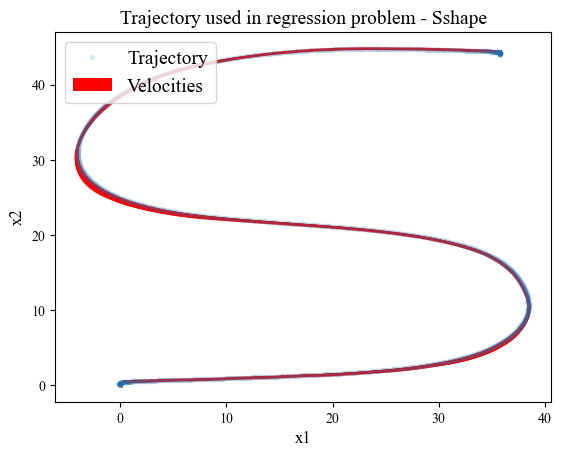

In [448]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('Trajectory used in regression problem - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0,:], x_train[1,:], '.', alpha = 0.12)
plt.quiver(x_train[0,:], x_train[1,:], y_train[0,:], y_train[1,:], color = 'red', scale = 700)
plt.xlabel('x1', fontsize =12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Velocities'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_dataset.show()
#plt.savefig("../src/figures_plot/lasa_datatset.eps", format ="eps")

axes = plt.gca() #gca = get current axes, from my last plot

### From notebook: vector_valued_with_rff

In [449]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))

def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

#### Jacobian

In [450]:
def psi_derivative(x, w, b):
    return np.sqrt(2) * (-np.sin(w.T@x + b)) * w

""" def jacobian(x, w, b, m):
    # The sum of outer products
    sqrt = np.sqrt(2/m)
    sum_jacobian = np.zeros(m)
    for i in range(0, m):
        psi_vector = psi_vector_jacobian(x[:,i], w, b, m)
        sum_jacobian[i] = psi_vector.T@psi_vector
    return sqrt*sum_jacobian
 """
sigma = 5
num_of_samples = 100

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi

# Random Fourier features approx
lambda_ = 0.0001 # regularization parameter lamda

#jacobian(x_train, w, b, num_of_samples)

#### Finding alpha without constraint

In [451]:
def alpha_approx(x_vector, y, dim, m, lam, n):
    phi_ = phi(x_vector, w, b, n, m, dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    m_param = pc.Constant('m', m)
    #alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_param', (m_param*dim_param, 1))
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    #alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

#### Alpha with contraction constraint

In [452]:
def alpha_approx_with_constraint(x_vector, y, dim, m, lam, n, mu, const_points):
    phi_ = phi(x_vector, w, b, n, m, dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    m_param = pc.Constant('m', m)
    mu_param = pc.Constant('mu', mu)
    constraint_points = pc.Constant('const_points', const_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (m_param*dim_param, 1))
    ## Creating constraints
    for i in range(constraint_points):
        x = x_train[:, i]
        gradient = np.zeros(dim)
        for j in range(m):
            index = 2*j
            psi_derivative_param = pc.Constant('psi_derivative', psi_derivative(x, w[:, j], b[:, j]))
            jacobi = alpha_var[index:index+2] * psi_derivative_param.T
            gradient = gradient + 0.5 * (jacobi + jacobi.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

### Random Fourier Features & Regression

In [453]:
sigma = 10
num_of_samples = 100
num_of_contraction_points = 250

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi

# Random Fourier features approx
lambda_ = 0.1 # regularization parameter lamda
mu = 0.0

""" alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)
print(alpha_array_rff.shape) """

alpha_array_rff = alpha_approx_with_constraint(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_contraction_points)
print(alpha_array_rff.shape)

# Create callable function for learnt dynamics (straight from working note)
def learnt_model(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func

# learnt_model as lambda function
#F = lambda t, x: capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff

(400,)


#### Solve diff. equation using learnt model w. solver_ivp

In [454]:
timespan = np.array([time_series[0],time_series[-1]])
t = np.linspace(time_series[0],time_series[-1], 1000)
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval = t).y


### Plot simulated trajectory and streamslices for learnt model

In [455]:
# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points = 17

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0
#print(data_series)
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i,j), value in np.ndenumerate(X1):

    # get velocities at each point with the learnt model
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

#### Combined solution and vector field for learnt model

C:\Users\vilde\AppData\Local\Temp\ipykernel_15888\2566609994.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel.show()


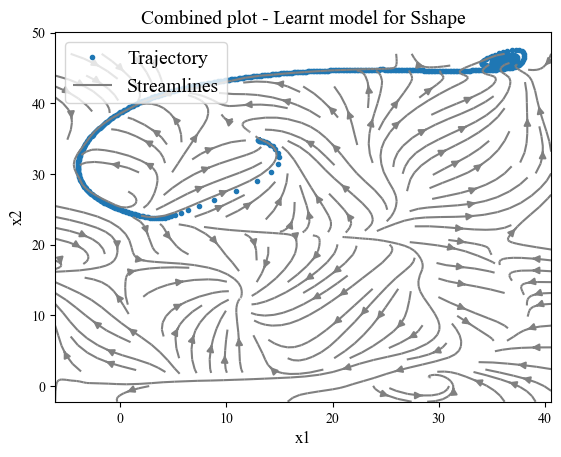

In [456]:
fig_learntmodel = plt.figure(2)
plt.title('Combined plot - Learnt model for ' + name_of_dataset, fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel.show()
#plt.savefig("../src/figures_plot/lasa_learnt_model.eps", format ="eps")

In [457]:
'''
#!/usr/bin/env python3

import numpy as np
import picos as pc
from matplotlib import pyplot
from scipy import spatial

# Make the result reproducible.
np.random.seed(12)

# Define the data.
n = 20
A = np.random.rand(2, n)
b = np.array([1, 0])

# Define the decision variable.
x = pc.RealVariable("x", n)

# Define and solve the problem.
P = pc.Problem()
P.minimize = abs(A*x - b)
P += pc.sum(x) == 1, x >= 0
P.solve(solver='mosek')

# Obtain the projection point.
p = (A*x).np

# Plot the results.
V = spatial.ConvexHull(A.T).vertices
figure = pyplot.figure(figsize=(8.7, 4))
figure.gca().set_aspect("equal")
pyplot.axis("off")
pyplot.fill(A.T[V, 0], A.T[V, 1], "lightgray")
pyplot.plot(A.T[:, 0], A.T[:, 1], "k.")
pyplot.plot(*zip(b, p), "k.--")
pyplot.annotate("$\mathrm{conv} \{a_1, \ldots, a_n\}$", [0.25, 0.5])
pyplot.annotate("$b$", b + 1/100)
pyplot.annotate("$Ax$", p + 1/100)
pyplot.tight_layout()
pyplot.show()
'''

'\n#!/usr/bin/env python3\n\nimport numpy as np\nimport picos as pc\nfrom matplotlib import pyplot\nfrom scipy import spatial\n\n# Make the result reproducible.\nnp.random.seed(12)\n\n# Define the data.\nn = 20\nA = np.random.rand(2, n)\nb = np.array([1, 0])\n\n# Define the decision variable.\nx = pc.RealVariable("x", n)\n\n# Define and solve the problem.\nP = pc.Problem()\nP.minimize = abs(A*x - b)\nP += pc.sum(x) == 1, x >= 0\nP.solve(solver=\'mosek\')\n\n# Obtain the projection point.\np = (A*x).np\n\n# Plot the results.\nV = spatial.ConvexHull(A.T).vertices\nfigure = pyplot.figure(figsize=(8.7, 4))\nfigure.gca().set_aspect("equal")\npyplot.axis("off")\npyplot.fill(A.T[V, 0], A.T[V, 1], "lightgray")\npyplot.plot(A.T[:, 0], A.T[:, 1], "k.")\npyplot.plot(*zip(b, p), "k.--")\npyplot.annotate("$\\mathrm{conv} \\{a_1, \\ldots, a_n\\}$", [0.25, 0.5])\npyplot.annotate("$b$", b + 1/100)\npyplot.annotate("$Ax$", p + 1/100)\npyplot.tight_layout()\npyplot.show()\n'

In [458]:
# Checks the available solvers
pc.solvers.available_solvers(problem=None)

['cvxopt', 'mosek', 'mskfsn']